# Imports

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import json
from glob import glob
from pathlib import Path
from PIL import Image as Image_PIL
import imghdr # built in module
import numpy as np
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
import pandas as pd

In [3]:
!which python

/usr/local/bin/python


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Paths

In [0]:
# Data
path_gdrive = Path('/content/drive/My Drive/mushrooms')
data_folder = path_gdrive / 'data'


# Project
#project_path = Path.home() / 'repos_github/mushroom-identifier/'
#app_path = project_path / 'app'
#model_path = app_path / 'models'

## Load Mushroom Info

In [0]:
# df_mushrooms = pd.read_excel(project_path / 'data/mushrooms.xlsx', index_col=0)
# df_mushrooms.set_index('Index', inplace=True, drop=True)
# df_mushrooms.head()

# Train the model

## generate databunch

Add some data augmentation with `get_transforms`:

In [0]:
tfms = get_transforms(
    flip_vert=True,
    max_lighting=0.1,
    max_zoom=1.05,
    max_warp=0.5,
)

Define batch size, image size:

In [0]:
bs = 128  # 32,64,128       # batch_size
size = 128
np.random.seed(42) # set random seed so we always get the same validation set

Create an `ImageDataBunch` from `path` by splitting the data in folder and labelled in a file `csv_labels` between a training and validation set.

Use `valid_pct` to indicate the percentage of the total images to use as the validation set. An optional test folder contains unlabelled data and suffix contains an optional suffix to add to the filenames in `csv_labels` (such as '.jpg').
* `fn_col` is the index (or the name) of the the column containing the filenames and 
* `label_col` is the index (indices) (or the name(s)) of the column(s) containing the labels.
* Use `header` to specify the format of the csv header, and
* `delimiter` to specify a non-standard csv-field separator.

In case your csv has no header, column parameters can only be specified as indices. If `label_delim` is passed, split what's in the label column according to that separator.

In [0]:
# doc(ImageDataBunch)

In [0]:
src = (ImageList.from_folder(path=data_folder)
       .split_by_rand_pct(0.2)
       .label_from_folder())

## Train resnet34; image size=128 

In [0]:
img_data = (src.transform(tfms, size=128)
            .databunch()
            .normalize(imagenet_stats))

First image of the training dataset:

In [12]:
img_data.train_ds[0]

(Image (3, 128, 128), Category Amanita_Caesarea)

First image of the validation dataset:

In [13]:
img_data.valid_ds[0]

(Image (3, 128, 128), Category Amanita_Pahlloides)

Show some images from the dataset:

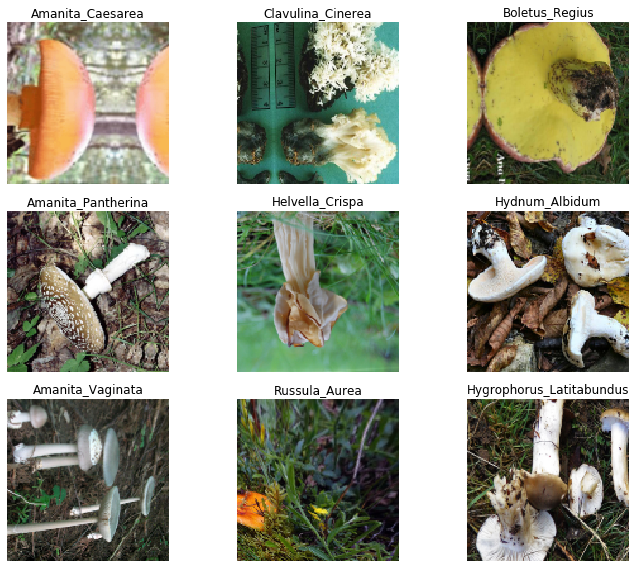

In [14]:
img_data.show_batch(rows=3, figsize=(10,8))

Number of classes in the dataset

In [15]:
# Number of categories
img_data.c

43

In [0]:
# Names of the categories
# img_data.classes

Set a learner with resnet34 architecture

In [0]:
# model = cnn_learner(img_data, models.resnet34, metrics=[accuracy, error_rate])
# model = cnn_learner(img_data, models.resnet34, metrics=[error_rate])

# Used in multi label classifier:
# acc_02 = partial(accuracy_thresh, thresh=0.2)
# f_score = partial(fbeta, thresh=0.2)
# model = cnn_learner(img_data, models.resnet34, metrics=[acc_02, f_score])

model = cnn_learner(img_data, models.resnet34, metrics=[accuracy, error_rate])

In [18]:
model.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.787718,1.466028,0.573013,0.426987,05:04


In [0]:
model.save(path_gdrive / 'mushrooms_1_cycle')

In [20]:
model.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.131722,1.215155,0.627850,0.372150,05:07
1,1.746760,0.986232,0.689464,0.310536,05:06
2,1.542127,0.918059,0.717190,0.282810,04:59


In [0]:
model.save(path_gdrive / 'mushrooms_4_cycles')

Reload Model

In [0]:
model = model.load(path_gdrive / 'mushrooms_4_cycles')

In [0]:
interpret = ClassificationInterpretation.from_learner(model)

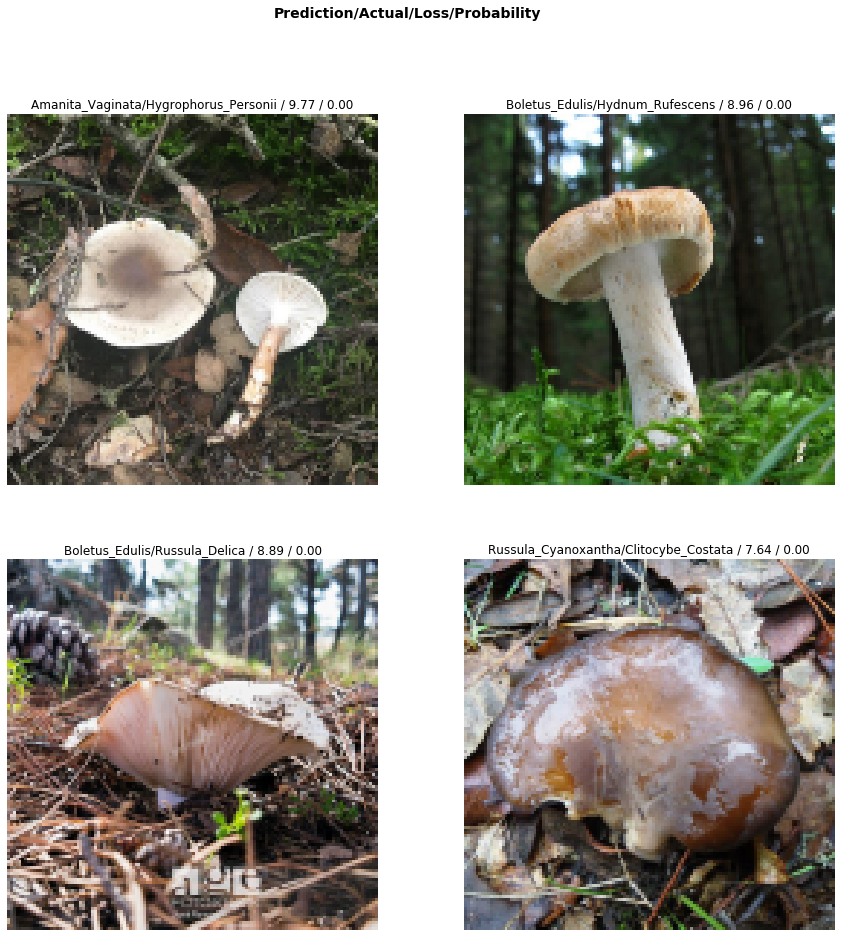

In [24]:
interpret.plot_top_losses(4, figsize=(15, 15))

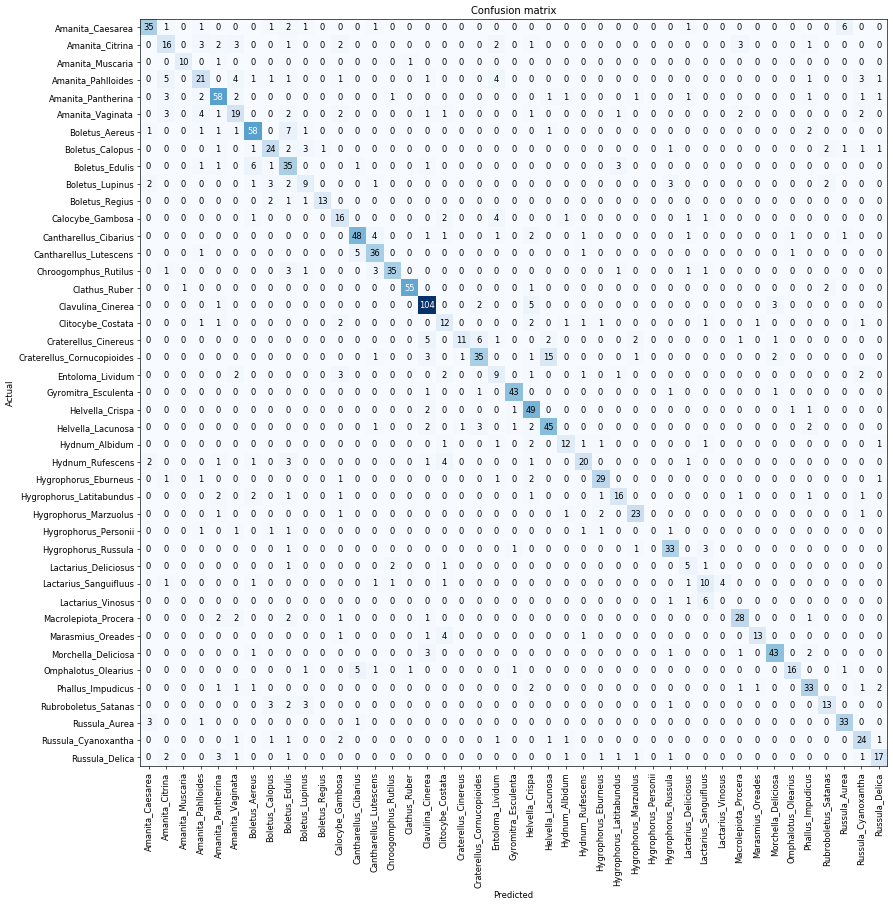

In [25]:
interpret.plot_confusion_matrix(figsize=(15,15), dpi=60)

In [28]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


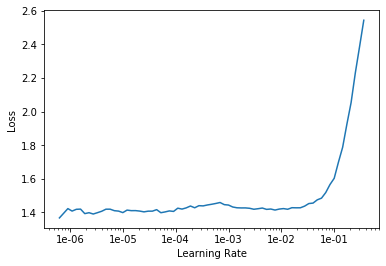

In [29]:
model.recorder.plot()

In [33]:
model.unfreeze()
model.fit_one_cycle(5, max_lr=slice(1e-06, 2e-02))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.751755,1.380032,0.632779,0.367221,05:08
1,1.643454,0.904195,0.739988,0.260012,05:08
2,1.180059,0.697902,0.783734,0.216266,05:09
3,0.913117,0.559903,0.825632,0.174368,05:05
4,0.736342,0.528959,0.837954,0.162046,04:59


In [0]:
model.save(path_gdrive / 'stage-1-128-rn34_lr_9_cycles')

In [0]:
model.export(path_gdrive / 'export_stage-1-128-rn34_lr_9_cycles.pkl')

In [36]:
model.fit_one_cycle(3, max_lr=slice(1e-06, 2e-02))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.938947,0.828716,0.770795,0.229205,05:02
1,0.971266,0.560892,0.838571,0.161429,05:03
2,0.691150,0.488865,0.857055,0.142945,05:05


In [0]:
model.freeze()

In [0]:
model.save(path_gdrive / 'stage-1-128-rn34_lr_12_cycles')
model.export(path_gdrive / 'export_stage-1-128-rn34_lr_12_cycles.pkl')

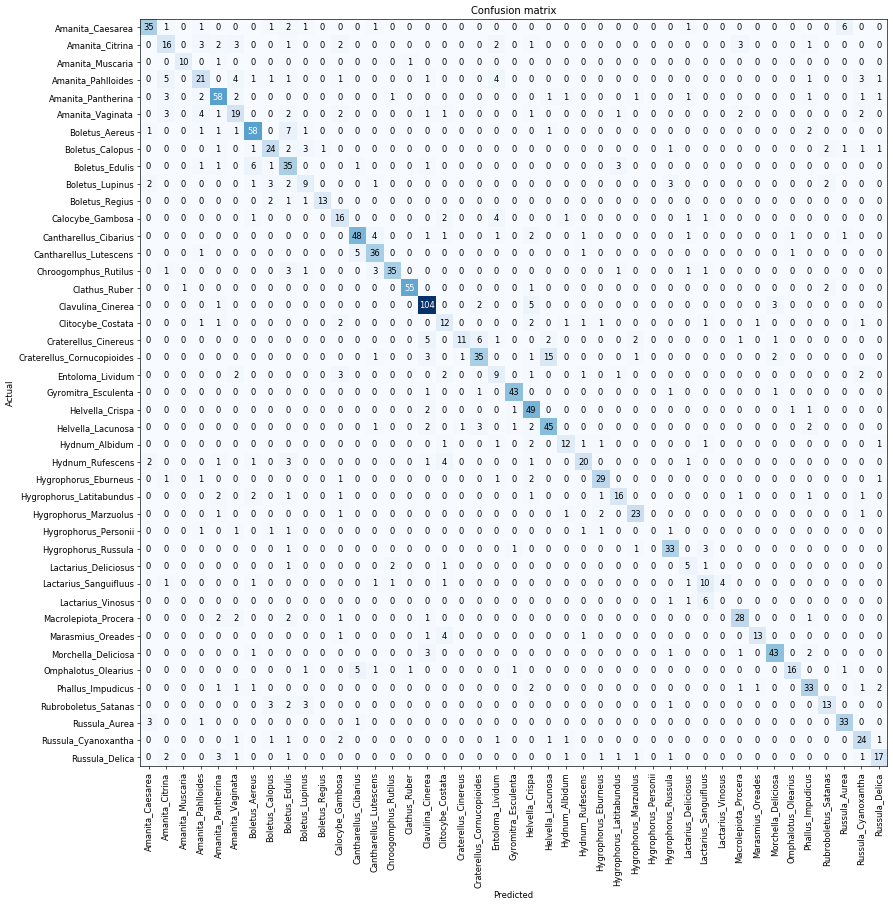

In [43]:
interpret.plot_confusion_matrix(figsize=(15,15), dpi=60)

In [0]:
# model.lr_find()

In [0]:
# model.recorder.plot()

In [0]:
# model.fit_one_cycle(5, max_lr=slice(1e-05, 1e-02))

In [0]:
# model.recorder.plot_losses()

## Train resnet34; image size=256

Do some data augmentation by creating new databunch with images of size=256

In [0]:
model = model.load(path_gdrive / 'stage-1-128-rn34_lr_12_cycles')

In [0]:
img_data = (src.transform(tfms, size=256)
            .databunch()
            .normalize(imagenet_stats))

In [0]:
model.data = img_data

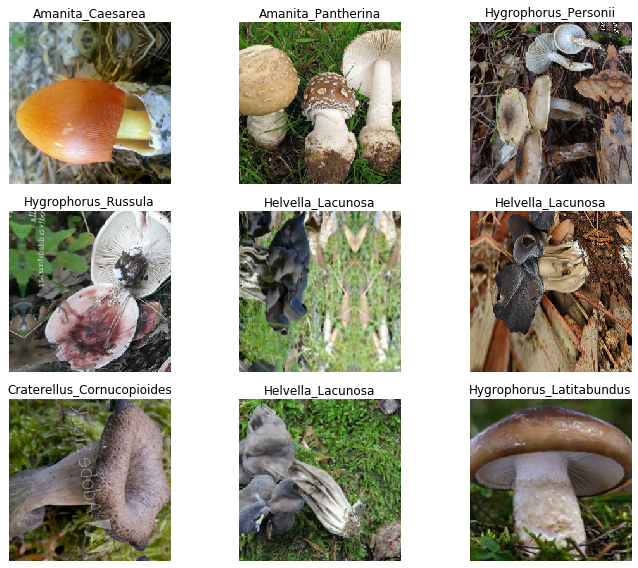

In [52]:
img_data.show_batch(rows=3, figsize=(10,8))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


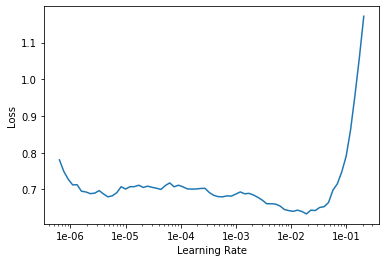

In [47]:
model.freeze()
model.lr_find()
model.recorder.plot()

In [53]:
model.unfreeze()
#model.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
___________________________________________________

In [54]:
model.fit_one_cycle(3, max_lr=slice(2e-03, 2e-02))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.902701,3.733612,0.367837,0.632163,06:58
1,1.625910,1.276102,0.605052,0.394948,06:52
2,1.101347,0.614866,0.815157,0.184843,06:53


In [55]:
model.fit_one_cycle(3, max_lr=slice(2e-03, 2e-02))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.428625,2.363594,0.406654,0.593346,06:55
1,1.501945,1.067961,0.675909,0.324091,06:54
2,0.997191,0.591575,0.804067,0.195933,06:55


In [56]:
model.fit_one_cycle(3, max_lr=slice(2e-03, 2e-02))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.320060,9.001352,0.428219,0.571781,06:55
1,1.337284,1.022305,0.691312,0.308688,07:04
2,0.894037,0.534860,0.826248,0.173752,06:59


In [0]:
model.save(path_gdrive / 'stage-2-256-rn34_lr_9_cycles')

In [0]:
model.export(path_gdrive / 'export_stage-2-256-rn34_lr_9_cycles.pkl')

In [59]:
# model.load(path_gdrive / 'stage-2-256-rn34_lr_9_cycles')

Learner(data=ImageDataBunch;

Train: LabelList (6496 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Amanita_Caesarea,Amanita_Caesarea,Amanita_Caesarea,Amanita_Caesarea,Amanita_Caesarea
Path: /content/drive/My Drive/mushrooms/data;

Valid: LabelList (1623 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Amanita_Pahlloides,Helvella_Lacunosa,Clavulina_Cinerea,Hydnum_Rufescens,Russula_Aurea
Path: /content/drive/My Drive/mushrooms/data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
       

Try different approach, reload stage-1 model and run one_cycle before unfreezing:

In [0]:
model = model.load(path_gdrive / 'stage-1-128-rn34_lr_12_cycles')

In [0]:
img_data = (src.transform(tfms, size=256)
            .databunch()
            .normalize(imagenet_stats))

In [0]:
model.data = img_data

In [0]:
model.freeze()

In [0]:
learn.fit_one_cycle(3)

# Test model with other images:

In [0]:
learn = load_learner(model_path)

In [0]:
image_path = Path.home() / 'rovello.jpg'

In [0]:
img = open_image(image_path)

In [0]:
Path.home() / 'rovello.jpg'

In [0]:
learn.predict(img)

In [0]:
Path.home()

# Deploy Web Page with Elastic Beanstalk

Tutorial Client: https://docs.aws.amazon.com/elasticbeanstalk/latest/dg/eb-cli3.html

Titorial Bundle: https://docs.aws.amazon.com/elasticbeanstalk/latest/dg/applications-sourcebundle.html

# References

* [Fastai multi label](https://gilberttanner.com/blog/fastai-multi-label-image-classification)
* [Google images scrapping](https://medium.com/@intprogrammer/how-to-scrape-google-for-images-to-train-your-machine-learning-classifiers-on-565076972ce)
* [Basic mushroom info](https://bolets.info/)
* [Mushroom names in Latin and additional info](https://ca.wikipedia.org/)
* [Instagram @natros56](https://www.instagram.com/explore/tags/indexboletsnatros56_cat/)




# Not Used